# Title: Enhanced Markowitz Stock Portfolio Optimization Using PCA and Random Matrix Theory

## Abstract:

This study enhances the classical Markowitz portfolio optimization framework by addressing one of its core weaknesses: the instability of covariance estimation in high-dimensional financial data. Using daily returns from the full S&P 500 universe, we construct and compare three portfolio pipelines—Raw Covariance, PCA-Processed Covariance, and Random Matrix Theory (RMT)–Cleaned Covariance. PCA is used to extract dominant market factors and reduce dimensionality, while RMT filters out noise by isolating statistically significant eigenvalues from the bulk spectrum. Each covariance model is then applied to generate minimum-variance and maximum-Sharpe portfolios. This enables us to focus on understanding the structural differences between the three methods and illustrates how PCA and RMT alter the underlying risk representation within the Markowitz optimization pipeline.

## Problem Statement:

Traditional Markowitz portfolio optimization relies heavily on the sample covariance matrix, which becomes unstable and unreliable when the number of assets is close to the number of observations, as is the case with the S&P 500. This instability can cause extreme weight allocations, sensitivity to noise, and inconsistent portfolio construction. The problem addressed in this study is how different covariance estimation techniques—Raw, PCA-processed, and RMT-cleaned—change the structure of the risk model and influence the resulting minimum-variance and maximum-Sharpe portfolios. The goal is to understand how noise reduction and factor extraction modify the behavior of Markowitz optimization in a high-dimensional equity setting.

## Motivation

This project is motivated by the need to understand how different covariance estimation techniques—Raw, PCA-reduced, and RMT-cleaned—affect the construction of optimized portfolios under these challenging conditions.

In particular, we seek to:

1. Explore various portfolio options based on different risk appetites, by generating minimum-variance and maximum-Sharpe portfolios under each covariance model.

2. Address portfolio instability, especially the tendency of raw Markowitz optimization to produce extreme or highly sensitive weight allocations in high-dimensional settings.

3. Evaluate whether alternative covariance estimation methods can generate portfolios that compare favorably to a broad market benchmark such as the S&P 500, not as a performance guarantee, but as an exploratory exercise in understanding structural differences.

Overall, the motivation is to examine whether noise-filtered and factor-based risk models offer practical advantages when constructing portfolios in a large-universe equity environment.

## Limitations

Several limitations should be acknowledged. 

First, the method relies entirely on historical stock data, which implicitly assumes that past statistical relationships will persist into the future. This assumption may fail during periods of structural change, regime shifts, or unexpected market shocks.

Second, although we incorporate the idea of rolling validation to assess stability through time, this validation is performed manually and only at selected time slices (e.g., Q1, Q2, and Q3). As a result, the analysis does not continuously track how model performance evolves across all periods. This limited implementation may overlook drift, or gradual shifts in covariance structure and portfolio behavior, which could significantly affect the robustness of Raw, PCA, and RMT-based portfolios.

Third, the study uses only stocks from the S&P 500, which represent large-cap U.S. equities. While convenient and well-behaved from a data quality standpoint, this universe does not capture the characteristics of other markets such as mid-caps, emerging markets, regional markets, or alternative assets.

These limitations suggest that while the methodology offers useful insights into covariance estimation techniques, further research is required to validate robustness across time, across markets, and under different economic conditions.

## Data Exploration

### Data Source


The dataset used in this study originates from two publicly accessible sources:

1. Wikipedia – List of S&P 500 Companies

The official S&P 500 constituent list is scraped from the public Wikipedia page
“List of S&P 500 companies”.

Wikipedia maintains a regularly updated list of companies included in the S&P 500 index, along with tickers, GICS sectors, and sub-industries.

2. Yahoo Finance – Historical Market Data

After obtaining the list of tickers, we download historical daily market data from January 2020 to November 21, 2025 using the yfinance API.

Yahoo Finance provides OHLC (Open, High, Low, Close), Adjusted Close, and Volume data for all publicly listed U.S. equities.

This combination provides a complete and up-to-date dataset of S&P 500 constituents with their historical prices.

### Data Fields

Data has already been gathered as a CSV file (sp500long.csv). Within this dataset contains the following columns:

> * `Date` - The trading date corresponding to the recorded stock price and volume data. Each entry represents a single trading day in the historical time series.
> * `Ticker` - The unique stock symbol or code assigned to each company (e.g., AAPL for Apple Inc., MSFT for Microsoft Corp.), used to identify the asset in financial markets.
> * `Adj Close` - The adjusted closing price of the stock for the given date. This value accounts for corporate actions such as dividends, stock splits, and new share issuances, providing a consistent measure of a stock’s true value over time.
> * `Close` - The raw closing price of the stock on that trading day, representing the last transaction price before the market closes, without adjustments for corporate actions.
> * `High` - The highest price at which the stock traded during the day’s trading session. It reflects the maximum price investors were willing to pay for the stock that day.
> * `Low` - The lowest price at which the stock traded during the day’s trading session. It reflects the minimum price investors were willing to accept for the stock that day.
> * `Open` - The price of the first trade executed when the market opened on that trading day. It may differ from the previous day’s close due to overnight news or market sentiment changes.
> * `Volume` - The total number of shares traded during the day. It measures the trading activity or liquidity of the stock, higher volumes indicate stronger investor participation and price reliability.


## Data Loading

To construct the dataset for this study, we begin by scraping the complete list of S&P 500 constituents from the publicly available Wikipedia page, `List of S&P 500 companies.` Using the requests library with custom headers to avoid blocking, we retrieve the HTML content and extract the relevant table via `pandas.read_html`. The stock tickers obtained from this table are then cleaned to match Yahoo Finance’s formatting conventions (replacing periods with hyphens) and supplemented with the `^GSPC` index ticker for benchmarking. Historical price data for all symbols is retrieved from Yahoo Finance using the yfinance API. Because downloading all tickers at once can lead to API throttling, the tickers are processed in batches of 100, and each batch is downloaded with full OHLCV fields under a consistent daily interval. The batch results are assembled into a MultiIndex “wide” table and then reshaped into a “long” format where each row represents a specific ticker-date observation. This final dataset is saved as `sp500long.csv` and serves as the foundation for subsequent return calculations, covariance estimation, PCA analysis, RMT filtering, and portfolio optimization.

## Data Cleaning and Preparation

This step is stored within the `"data_prep.py"` module. We first load the full historical price dataset that was scraped from Yahoo Finance and stored as a long-form CSV file. The data include daily OHLCV information for every S&P 500 stock, as well as the index itself (`^GSPC`). Dates are converted into proper datetime format, and the index ticker is filtered out when preparing the stock-level dataset, as it is not part of the investable universe used for portfolio construction. We retain only the fields necessary for computing returns—specifically, `Date`, `Ticker`, and `Close`—and sort each ticker’s price history chronologically to ensure correct temporal ordering.

Daily returns are then computed using percentage changes in closing prices on a per-ticker basis. Because the first return of each series is undefined, rows containing missing return values are removed. The cleaned returns are assembled into a structured returns matrix, where rows represent trading dates and columns represent tickers. This matrix provides the necessary input for estimating the raw covariance matrix and for applying PCA- and RMT-based covariance transformations.

To ensure data completeness, we compute the fraction of missing returns for each ticker and report those with non-zero missing values. This step identifies securities with short trading histories, incomplete data, or structural gaps that may bias covariance estimation. Only tickers with fully observed return histories are used in subsequent optimization stages.

Finally, we construct benchmark series for the S&P 500 index (`^GSPC`). The module extracts the index’s closing prices, computes daily returns, and produces a cumulative return curve starting from a specified split date. In addition, the pipeline allows for summary statistics—such as mean daily return and volatility—to be computed over any date window. These benchmark series are later used to evaluate the performance of the constructed portfolios relative to the broader market.

## Methodological Process Flow

The methodology begins with the acquisition and preprocessing of historical daily price data (OHLC or Adjusted Close) for all S&P 500 constituents. After collecting the data, problematic tickers are removed, dates are sorted, and missing values are addressed to produce a clean dataset suitable for quantitative analysis. 

These prices are then converted into daily returns, which are assembled into a structured returns matrix with trading dates as rows and stocks as columns. Using this matrix, we compute the empirical sample covariance, which serves as the baseline estimate of cross-asset risk relationships.

From this point, the workflow branches into three covariance enhancement pathways. 

1. Path A, the raw covariance matrix is used directly to generate classical Markowitz portfolios—specifically, the minimum-variance and maximum-Sharpe allocations. 
2. Path B applies Principal Component Analysis (PCA) to extract the dominant market factors and reconstruct a reduced, noise-filtered covariance matrix, which is then used to compute PCA-based minimum-variance and maximum-Sharpe portfolios. 
3. Path C employs Random Matrix Theory (RMT) by analyzing the eigenvalue spectrum of the correlation matrix, identifying the noise bulk via the Marchenko–Pastur distribution, shrinking noisy eigenvalues, and reconstructing an RMT-denoised covariance matrix. 

This cleaned matrix is then used to generate RMT-based minimum-variance and maximum-Sharpe portfolios. Finally, all six optimized portfolios—Raw MinVar, Raw MaxSharpe, PCA MinVar, PCA MaxSharpe, RMT MinVar, and RMT MaxSharpe—are consolidated and analyzed to evaluate how different covariance estimation techniques influence portfolio construction outcomes.

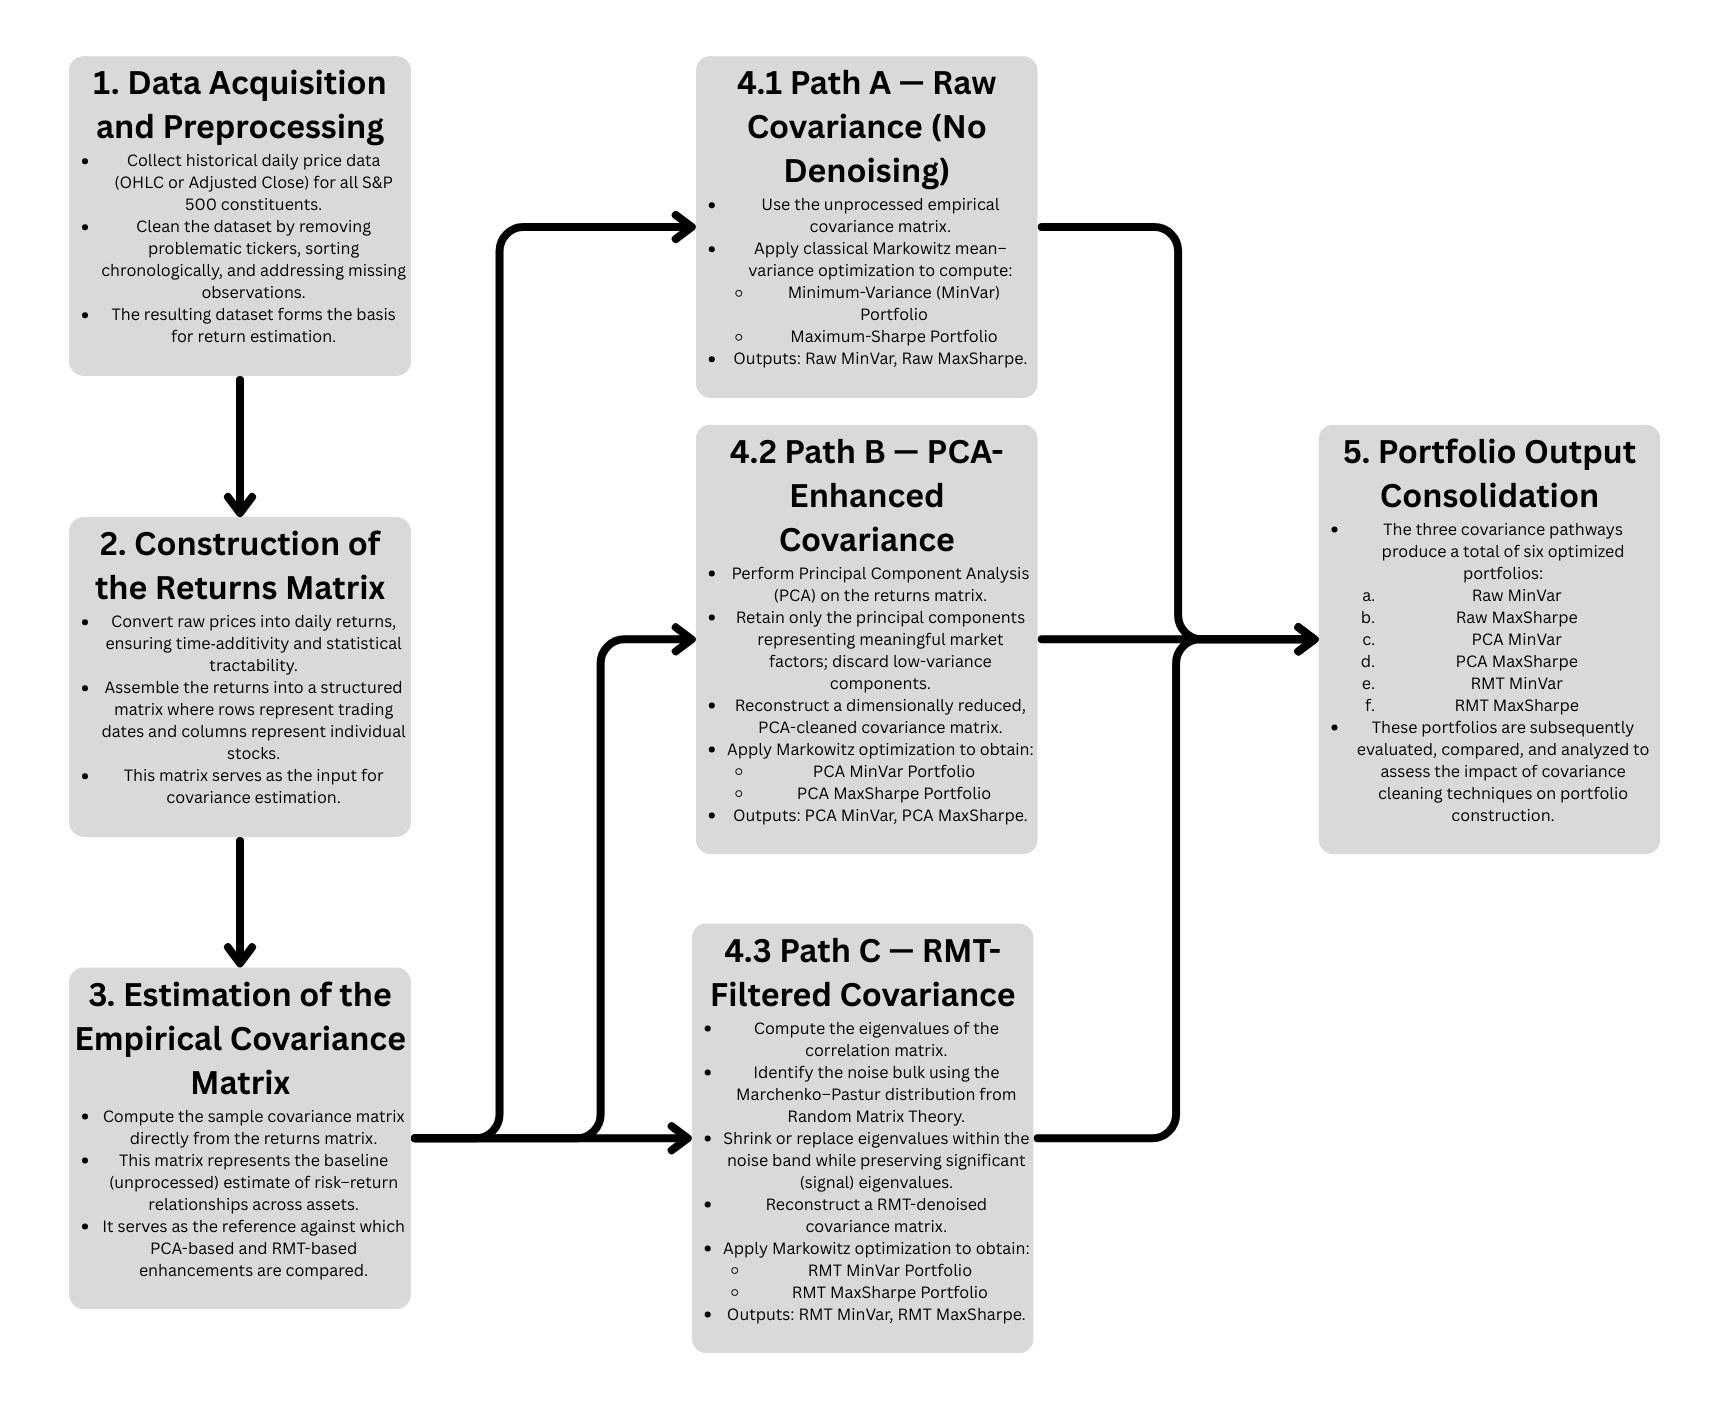

In [2]:
from IPython.display import Image
Image("flowchart.png")

# Methodology
The following methodology details the mathematical framework and procedural steps employed in this study. The research builds upon the foundational Mean-Variance Optimization model introduced by Harry Markowitz (Avellaneda, 2010), while integrating advanced statistical techniques, specifically Principal Component Analysis (PCA) and Random Matrix Theory (RMT), to mitigate the limitations of empirical covariance estimation in high-dimensional equity universes. The study also aims to isolate risk factors using the minimum volatility portfolio from random noise and maximize the returns using the Sharpe portfolio, and thereby construct a robust investment portfolio. The training data are from daily market data from January 2020 to December 2024, while the testing data are from January 2025 to September 2025. 
 
## Markowitz Portfolio Optimization (Using Markowitz Mean-Variance Model)
 
The core of the optimization process relies on the Modern Portfolio Theory (MPT) framework, which quantifies the trade-off between risk and returns that was introduced by Harry Markowitz (Markowitz, 1952). The mathematical formulation necessitates the computation of the covariance matrix, denoted as $C$, which captures the co-movement between asset returns. This is defined as the covariance of the returns matrix $R$. To evaluate portfolio performance, two primary metrics are calculated. First, the expected return of the portfolio, $\mu_{portfolio}$, is derived as the weighted sum of individual asset returns, represented by the equation $\mu_{portfolio} = \mu^T w$, where $\mu$ is the vector of expected asset returns and $w$ represents the portfolio weight vector. Second, the portfolio volatility (risk), denoted as $\sigma_{portfolio}$, is calculated as the standard deviation of the portfolio returns, expressed as $\sigma_{portfolio} = \sqrt{w^T C w}$.

## Covariance Matrix Filtering via Principal Component Analysis
A significant challenge in applying Markowitz optimization to large datasets is that the covariance matrix often contains substantial noise, particularly when the number of assets is large relative to the number of historical observations (Avellaneda, 2010). To mitigate this, the study employs Principal Component Analysis (PCA) as a dimensionality reduction technique. The process begins by standardizing the returns matrix to ensure scale invariance. Subsequently, the covariance matrix is decomposed into its eigenvalues and eigenvectors. The methodology assumes that the most significant market movements are captured by the largest eigenvalues, while the smallest eigenvalues largely represent noise. Therefore, the study retains only the top principal components that cumulatively explain 90% of the total variance. The remaining components are discarded. The covariance matrix is then reconstructed using only these significant components, resulting in a low-noise, more stable covariance matrix, improving portfolio optimization.

## Statistical Denoising using Random Matrix Theory
Complementing the PCA approach, this research utilizes Random Matrix Theory (RMT) to provide a rigorous statistical threshold for distinguishing signal from noise. Unlike PCA, which relies on a fixed variance threshold, RMT compares the empirical correlation matrix of asset returns against the theoretical properties of a random matrix. The methodology starts with the normalization of the covariance $C$, resulting in a correlation matrix and decomposing the correlation matrix into its eigen-spectrum. The separation of meaningful information from noise is governed by the Marchenko-Pastur distribution, which defines the upper bound of eigenvalues for a purely random matrix (Avellaneda, 2010). This threshold, denoted as $\lambda_+$, is mathematically determined by the ratio of the number of assets ($N$) to the number of time observations ($T$), calculated as
 
$$\lambda_{+} = \sigma^2 \Big(1+\sqrt{q} \Big)^2, \quad \text{where } q=\frac{N}{T} \quad \text{ and } \sigma^2 =1 $$
 
because the main diagonal of the correlation matrix is equal to 1. Eigenvalues falling below the threshold are identified as noise and are replaced by the $\lambda_+$ value to dampen their influence. A cleaned covariance matrix is subsequently reconstructed from these filtered eigenvalues, producing a cleaned covariance matrix for the optimization algorithms.

## Markowitz Optimization Algorithms and Portfolio Construction
With the raw covariance matrix $C$ and enhanced covariance matrices derived from PCA and RMT, the study proceeds to solve for specific optimal portfolios. The first strategy isolates the Minimum Volatility Portfolio (MinVar), which identifies the specific allocation of weights that minimizes the total portfolio risk, subject to the constraint that the sum of weights equals 1, $\Big(\sum_{i} w_i = 1 \Big)$ using the idea of Dirichlet's distance (Horvarth, 2017) with $\alpha = 0.001$. 

The **Minimum Volatility Portfolio** is the allocation that achieves the lowest possible risk for a fully invested portfolio. This is obtained by solving the expression below:
$$\min_w w^T C_w \quad \text{such that } \sum_{i=1}^N w_i =1, \quad 0 \leq w_i \leq 1.$$
The implementation of this uses `scipy.optimize.minimize` with the following constraints:
- Sum of the weights should be equal to 1, i.e., $\big(\sum_i = 1\big)$, and
- No short selling (all weights are greater than or equal to 0), i.e., $0 \leq w_i \leq 1$.

The second strategy computes the **Maximum Sharpe Portfolio**, which optimizes the efficiency of the portfolio by maximizing the ratio $\Big(\max_{w} \frac{\mu^T w - R_f}{\sqrt{w^T C w}} \Big)$ of excess returns to portfolio volatility. 
The Maximum Sharpe Portfolio is the portfolio that yields the highest risk-adjusted return (Sharpe ratio), that is, 
$$\max_w \frac{\mu^Tw-R_f}{{\sqrt{w^T C_w}}} \quad \text{such that } \sum_{i=1}^N w_i=1, \quad 0 \leq w_i \leq 1.$$

A risk-free rate of 4% was used in this study, since the short-term US Treasury yields have stabilized around this figure (Bloomberg L.P., 2025). This was implemented using the `minimize()` function on the negative Sharpe ratio. The constraints imposed in looking minimizing the volatility (sum of weights is equal to 1 and all weights are nonnegative.


Finally, the entire Efficient Frontier is mapped by iteratively minimizing variance for a sequence of target returns, thereby providing a comprehensive visualization of the optimal investment landscape available under the covariances.
The **Efficient Frontier Portfolio** is the set of all portfolios that give the lowest risk for a given level of return. This is generated by solving a series of constrained optimization problems across a range of target expected returns. The grid of expected returns is created using the minimum and maximum elements of $\mu$:
$$ \mu_{\text{target}} \in \{\mu_{\min}, \ldots, \mu_{\max}\}.$$

For each target return, the optimizer solves
\[
\begin{aligned}
\min_{w} \quad & w^\top C\, w \\
\text{s.t.} \quad 
& \mu^\top w = \mu_{\text{target}}, \\
& \sum_i w_i = 1, \\
& 0 \le w_i \le 1 \quad \forall i.
\end{aligned}
\]

The resulting list of volatilities and weight vectors forms a discrete approximation of the efficient frontier. In implementation, `scipy.optimize.minimize` is used to solve each optimization problem under long-only and full-investment constraints. The output includes:
- portfolio volatilities along the frontier,
- corresponding weight allocations, and
- the grid of target expected returns.
 
This procedure yields the empirical efficient frontier for the given asset universe under long-only mean–variance optimization.

## Back Testing
To evaluate the robustness of the Markowitz, PCA-cleaned, and RMT cleaned portfolios, two sets of analyses are conducted:
1. Rolling-window stability assessment; and
2. Out-of-sample cumulative return backtesting.
### Rolling Stability
The rolling stability is assessed by recalculating the Markowitz frontier across multiple shifted training windows. Quarterly offsets were used (3,6, and 9 months). The dataset is re-split into new training tests and subsets:
$$\text{Train Window: }[\text{start} + k, \text{end}+k], \quad k\in {3,6,9} \text{ months}.$$
For each window, the following are recomputed/exctracted for the train window:
- Returns matrix
- Expected returns ($\mu$) and covariance ($\sigma$) of the returns matrix
- Minimum-volatility and maximum-Sharpe portfolios
- The efficient frontier is also rebuilt

This produces three frontiers (1Q 2025, 2Q 2025, and 3Q 2025) that can be compared visually. If the minimum-volatility and maximum-Sharpe portfolios generated from the 2020–2024 window continue to lie on, or very close to, the efficient frontiers of these later periods, this indicates that the original portfolio remains efficient despite the market environment shifts. In practical terms, this means the portfolio still does not require  rebalancing.

This rolling procedure is implemented in `fit_quarter_frontiers()` which returns frontier volatilities, weights, and target return grids for each shifted period.

### Out of Sample Cumulative Returns
The cumulative returns of the following portfolios for the year 2025 were graphed:
- Raw Markowitz (generated from 2020-2024 data)
  - Minimum volatility
  - Maximum Sharpe
- PCA-cleaned Markowitz (generated from 2020-2024 data)
  - Minimum volatility
  - Maximum Sharpe
- RMT-cleaned Markowitz (generated from 2020-2024 data)
  - Minimum volatility
  - Maximum Sharpe
**Daily portfolio returns** are computed as
$$ r_{p,t} = \sum_{i=1}^N w_ir_{i,t},$$
where $w_i$ are the optimized weights and $r_{i,t}$ are the daily returns of asset i.

**Cumulative returns** are then constructed as
$$\text{Cumulative Return}_t = \Pi_{\tau=1}^t(1+r_{p,\tau})-1 $$

This enables direct comparison of how each optimization method performs in new market conditions. The backtest is implemented via the function `compute_cumrets_all()` which returns both the cumulative and daily returns for all six portfolios. 

## Results and Discussion

In [20]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import utils as ut
import data_prep
import markowitz_analysis as ma
import markowitz_plots as mp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Preprocessing

In [21]:
# load data (one line)
stock_data_df, stock_data, stock_prices, returns_matrix = data_prep.load_sp500_data("sp500long.csv")

A returns matrix was initialized indexed by date, with individual tickers as columns.

In [3]:
# missing data report (one line)
missing_info = data_prep.report_missing_returns(returns_matrix)

Tickers with missing returns (non-zero):
Ticker
Q       0.993063
SOLS    0.991238
GEV     0.848120
SOLV    0.847755
VLTO    0.804308
KVUE    0.765973
GEHC    0.731289
CEG     0.647682
HOOD    0.603870
APP     0.577218
COIN    0.576853
EXE     0.561154
ABNB    0.546185
DASH    0.545820
PLTR    0.527930
OTIS    0.478642
CARR    0.478642
DDOG    0.433005
CRWD    0.407813
CTVA    0.403432
UBER    0.399781
DOW     0.386637
FOX     0.384812
FOXA    0.384447
MRNA    0.361446
DAY     0.304491
VICI    0.275648
IR      0.216867
INVH    0.191311
LW      0.171230
HWM     0.168675
VST     0.161738
TTD     0.158087
DELL    0.149325
FTV     0.138007
XYZ     0.081417
HPE     0.073019
PYPL    0.046002
KHC     0.046002
GDDY    0.021906
FISV    0.000365
dtype: float64


The tickers above are excluded from the data, as some records on the return matrix have null values and can thus be problematic.

In [ ]:
# raw Markowitz fit (one line)
raw = ma.fit_raw_markowitz(returns_matrix, stock_data, end_date="2024-12-31", risk_free=0.04/252, num_random=1000)

### Markowitz Efficient Frontiers

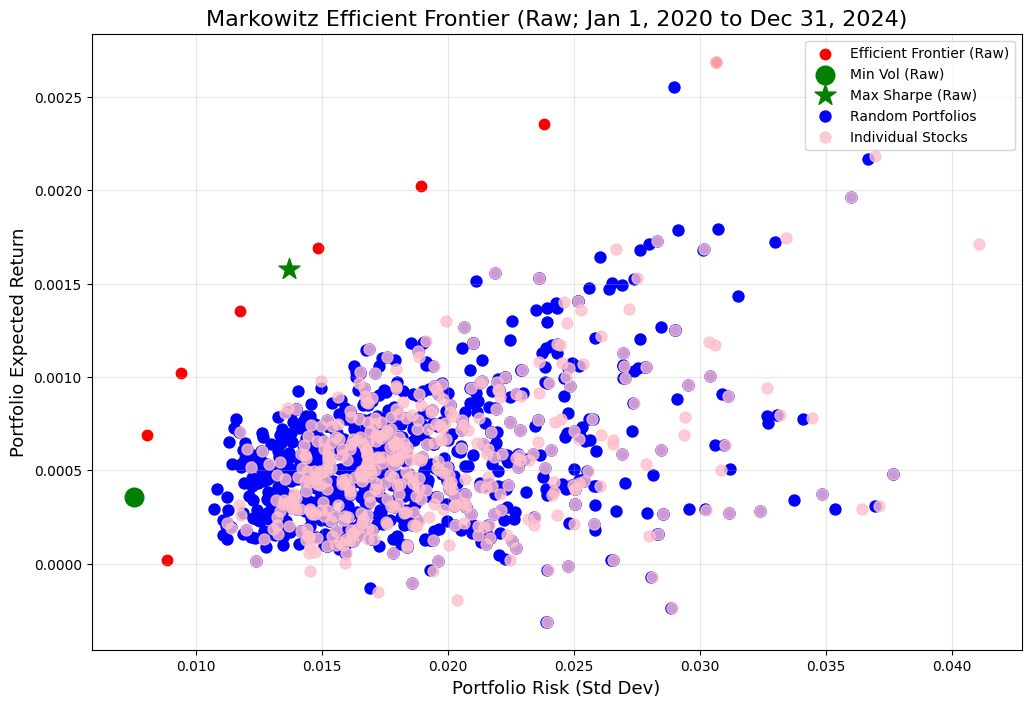

In [ ]:
# raw efficient frontier plot (one line)
mp.plot_frontier_raw(raw)

The chart shows the daily risk-return tradeoffs for portfolios built on stocks under the S&P500 with a 5-year look-back period. The red points trace the Markowitz efficient frontier: for each level of volatility on the x-axis, these portfolios deliver the highest expected return on the y-axis. The pink dots are individual stocks, which are widely scattered and generally offer more risk for a given level of expected return. The blue dots are randomly weighted portfolios on randomly sized and selected subsets of the S&P500. Most sit in a dense cloud below the red curve, meaning that naïve diversification improves risk-return relative to single stocks but is still usually inefficient. The green circle marks the minimum-volatility portfolio, which achieves very low daily risk with a modest positive expected return, while the green star is the maximum-Sharpe portfolio with an annual risk-free-rate of 4%, which offers the best trade-off between excess return and risk among all feasible portfolios. Overall, the plot illustrates how optimization shifts you upward and leftward, from individual stocks, to random portfolios, to an efficient set that dominates most other choices.

In [ ]:
# PCA-based Markowitz fit (one line)
pca = ma.fit_pca_markowitz(raw, risk_free=0.04/252, var_explained=0.90)

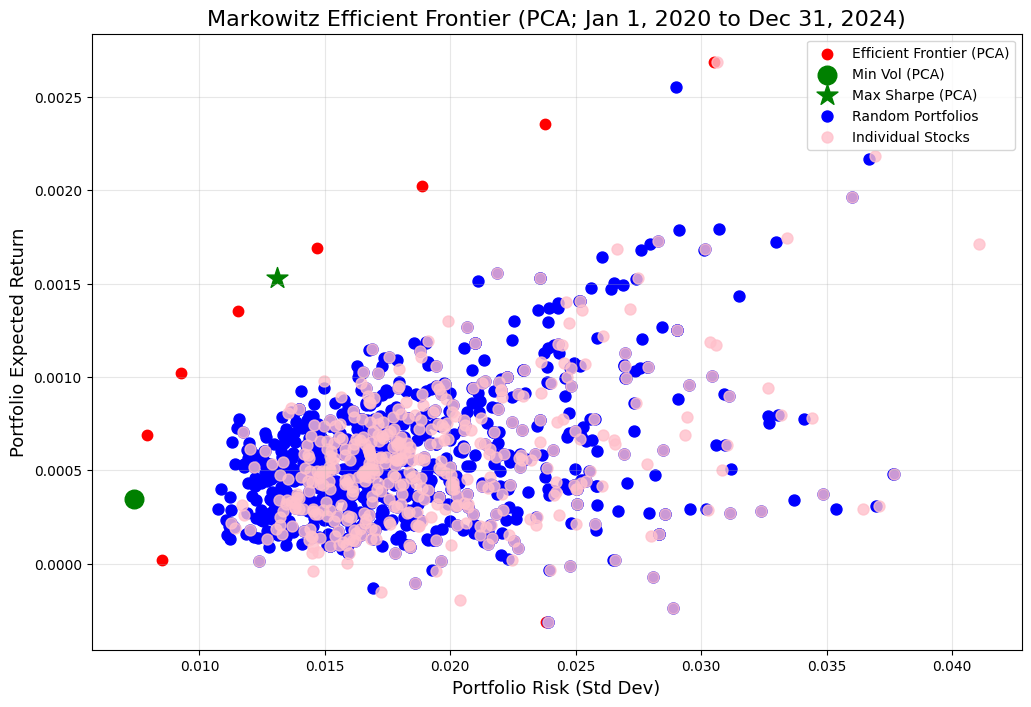

In [ ]:
# PCA efficient frontier plot (one line)
mp.plot_frontier_pca(raw, pca)

The figure above plots the same risk-return trade-offs for the randomly generated portfolios (blue) and individual stocks (pink) above. The Markowitz Efficient Frontier in this case is calculated with a PCA-denoised covariance matrix, with a 90% variance explained threshold. By compressing the 5-year covariance into a few dominant principal components, PCA preserves the main market and sector factors from this period while filtering out idiosyncratic, sample-specific noise (e.g., extreme co-movements during short-lived episodes). The PCA-based frontier slightly reshaped relative to the raw version, but it still lies in the same general region. This indicates that PCA is acting primarily as a regularization step: over a relatively long and potentially regime-changing 5-year window, it stabilizes the optimized portfolios without fundamentally altering the feasible set implied by the historical data.

In [ ]:
# RMT-based Markowitz fit (one line)
rmt = ma.fit_rmt_markowitz(raw, risk_free=0.04/252)

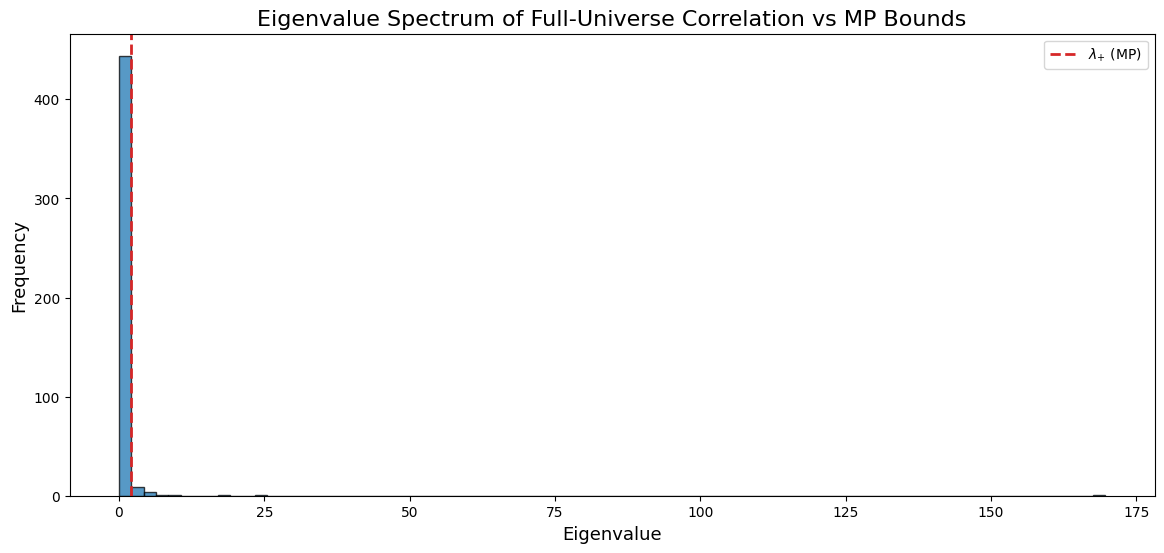

In [9]:
# RMT eigenvalue spectrum (one line)
mp.plot_rmt_spectrum(rmt)

The eigenvalue spectrum of the 5-year correlation matrix shows a very large bulk of eigenvalues tightly packed below the Marchenko-Pastur upper bound (red dashed line) and only a handful of very large outliers far to the right. Under random-matrix theory, eigenvalues that fall inside the MP bulk are indistinguishable from sampling noise given the ratio of assets to time points over this 5-year window, whereas the outliers represent genuine common risk factors such as the overall market and major sector modes. In the RMT-cleaned covariance used for optimization, the noisy bulk eigenvalues are shrunk toward a common value while the few signal eigenvalues are left intact, effectively filtering out unstable, sample-specific co-movements from the 5-year sample.

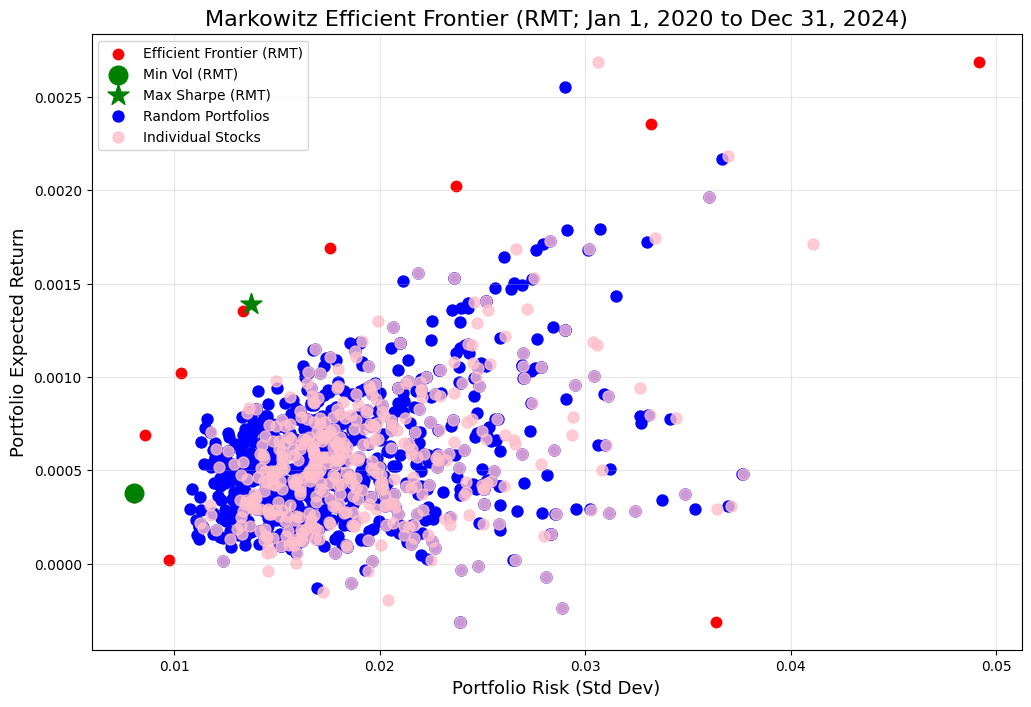

In [ ]:
# RMT efficient frontier plot (one line)
mp.plot_frontier_rmt(raw, rmt)

In the RMT case, the efficient frontier sits closer to the cloud of individual stocks and random portfolios, but this does not necessarily imply that the RMT portfolios are more inefficient. Rather, the raw 5-year covariance matrix likely overstates the apparent opportunities due to estimation noise, producing an in-sample frontier that lies unrealistically far above the bulk of feasible portfolios. By shrinking noisy eigenvalues and retaining only a few stable factors, RMT “deflates” these spurious risk-return combinations and pulls the optimized frontier inward toward the cloud. The result is a set of portfolios that appear less extreme in-sample, but are plausibly more robust and realistic out-of-sample than those derived from the unfiltered covariance matrix.


In [ ]:
# quarterly frontiers (one line)
quarter_results = ma.fit_quarter_frontiers(returns_matrix, stock_data_df, risk_free=0.04/252)


In [ ]:
# ^GSPC stats for each quarter (one line)
snp_stats = {
    key: data_prep.index_stats_in_window(stock_data_df, q["start"], q["end"])
    for key, q in quarter_results.items()
}

### Validation

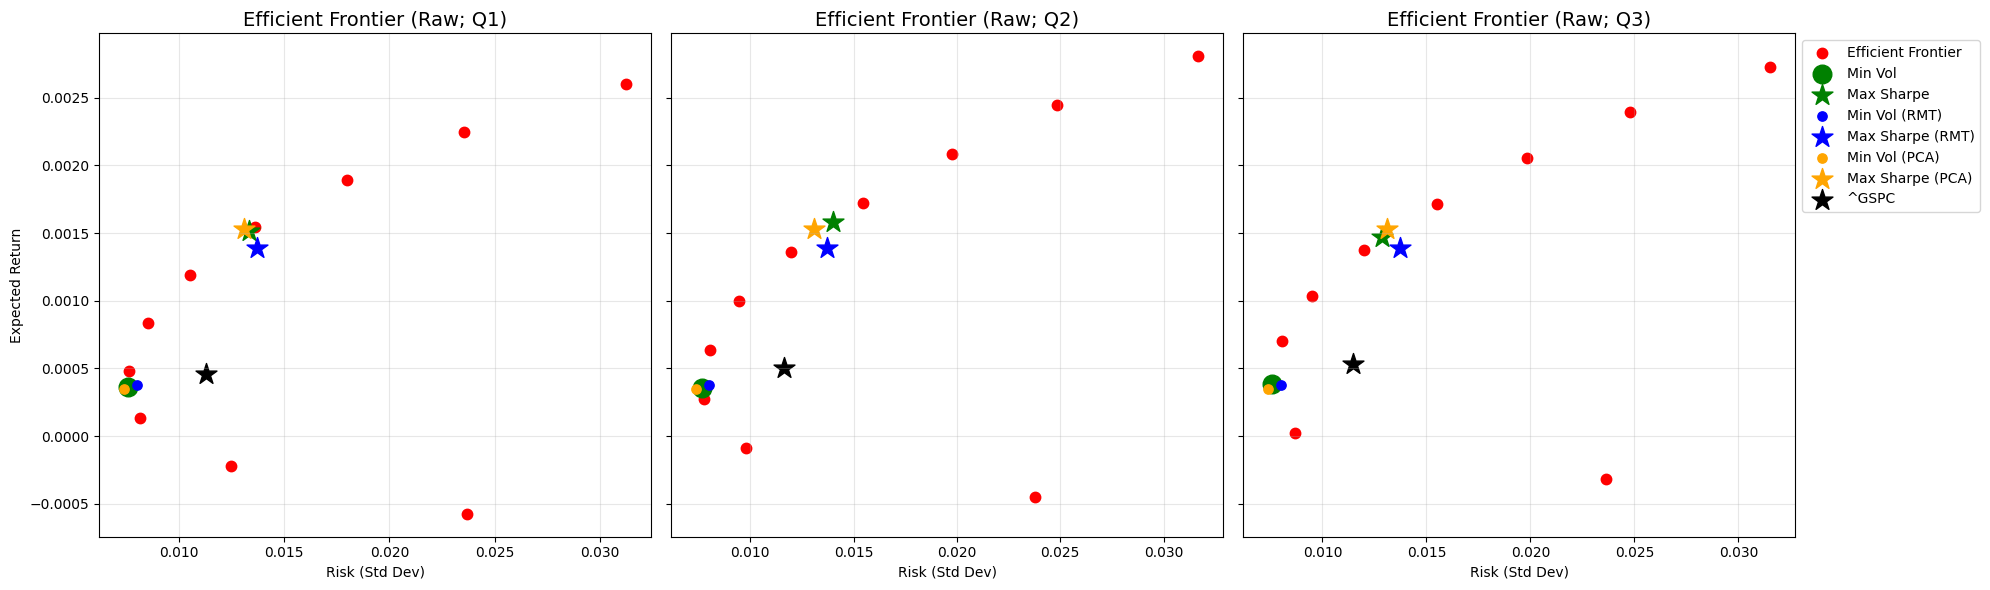

In [13]:
# quarterly comparison plots (one line)
mp.plot_quarter_frontiers(quarter_results, rmt, pca, snp_stats)

In finance, a rolling (or walk-forward) check is used to test how stable a model or strategy is through time. You fix an estimation window (e.g., the past 5 years of daily returns), estimate means and the covariance matrix on that window, build an efficient frontier and optimized portfolios, then roll the window forward by one period (e.g., a quarter) and repeat. Comparing results across windows shows whether the frontier, the “optimal” portfolios, and any benchmarks move smoothly or jump around; large shifts suggest that the optimization is very sensitive to the particular sample (potential overfitting), while small shifts indicate a more stable, robust structure.  

To check the robustness of portfolios generated with PCA and RMT cleaning, the minimum volatility and max-Sharpe ratio portfolios (with an annual risk-free rate of 4%) generated with a 5-year look-back period at the end of 2024. The expected daily return-risk tradeoffs from these portfolios were compared against a Markowitz Efficient Frontiers generated on the same-length look-back periods at the end of the first, second, and third quarters of 2025. The "outdated" and "regularized" portfolios (blue and orange) whether selected for minimum volatility or maximum Sharpe, stayed tightly grouped with their updated and "raw" counterparts. The S&P 500 point also remains close to the low-risk part of the frontier in all three quarters. Taken together, this suggests that over rolling 5-year windows the risk–return trade-off and the relative positions of the optimized and benchmark portfolios are fairly stable, and that the different covariance-cleaning methods mainly fine-tune rather than radically change the portfolio recommendations.

In [ ]:
# index series for out-of-sample period (one line)
snp_returns, snp_cum_ret = data_prep.build_index_series(stock_data_df, raw.split_date)

In [ ]:
# cumulative returns for all portfolios (one line)
cumrets = ma.compute_cumrets_all(raw, pca, rmt)

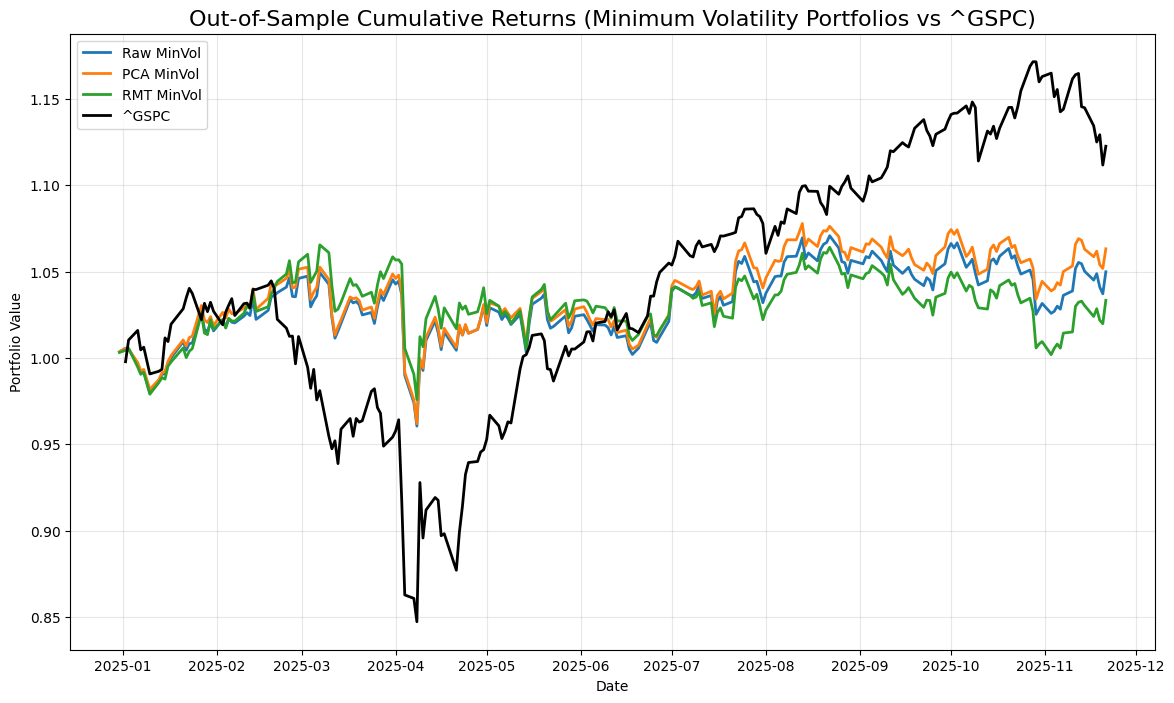

In [ ]:
# OOS cumulative returns – MinVol (one line)
mp.plot_cumrets_minvol(cumrets, snp_cum_ret)

The plot above visualizes cumulative returns (by measuring growth of every $1 invested). The three colored lines represent minimum-volatility Markowitz portfolios constructed using different covariance-cleaning approaches (Raw sample covariance, PCA-cleaned, RMT-cleaned). The black line is the benchmark (^GSPC). All three minimum-volatility portfolios produce smoother, more stable return paths than the benchmark. During the benchmark’s sharp drawdown around March-April 2025, the MinVol portfolios fall far less, demonstrating the structural effect of optimizing for low variance: they sacrifice some upside but substantially reduce downside. After the drawdown, all three portfolios converge to a tight cluster of outcomes, with PCA slightly outperforming Raw and RMT through most of the out-of-sample period. Their paths remain consistently below equity-index volatility yet achieve comparable or lower cumulative returns than the benchmark by November 2025. This indicates that, in this window, risk-reduction did not materially harm performance, and covariance cleaning (PCA, RMT) offers marginal differences relative to the raw estimator for this specific dataset and horizon.

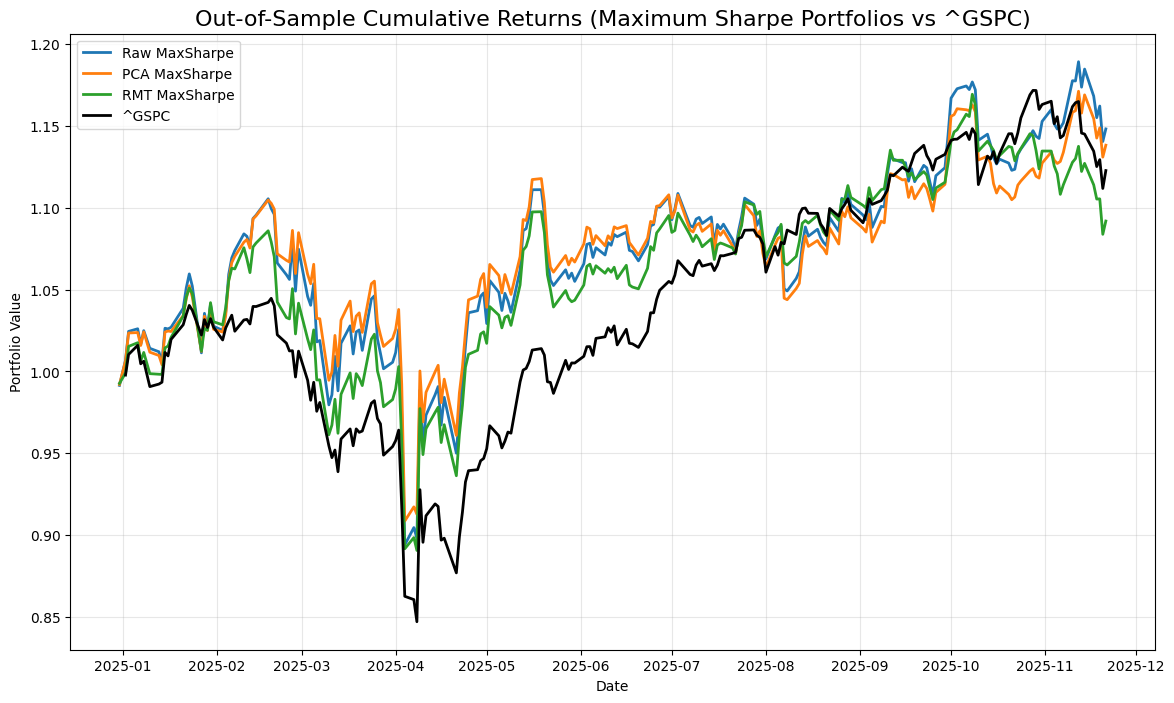

In [ ]:
# OOS cumulative returns – MaxSharpe (one line)
mp.plot_cumrets_maxsharpe(cumrets, snp_cum_ret)

These three lines are **maximum-Sharpe Markowitz portfolios** (Raw, PCA-cleaned, RMT-cleaned covariance), optimized using a 4% annual risk-free rate; the black line is ^GSPC.

Compared with the index, all three MaxSharpe portfolios take on more active risk but deliver **consistently higher cumulative returns** over the out-of-sample period. During the sharp drawdown around April 2025, they fall slightly more than in the MinVol case, but they still recover quickly and then **pull away from the benchmark**, finishing closer to 1.16–1.19 versus ~1.12 for ^GSPC. This is what you would expect from Sharpe-ratio optimization with a positive risk-free rate: the portfolios are tilted toward assets with strong excess return per unit of volatility, accepting a bit more variance for higher growth.

The three covariance estimators produce **very similar paths**—all outperform the index and track each other tightly. PCA and Raw appear marginally stronger than RMT near the end, but the differences are small relative to the common signal: under this sample and a 4% risk-free rate, max-Sharpe portfolios based on any of these covariance estimates would have beaten the index on a total-return basis.

In [23]:
# top 10 holdings per portfolio (one line)
tops = ma.top_holdings(raw, pca, rmt, top_n=10)

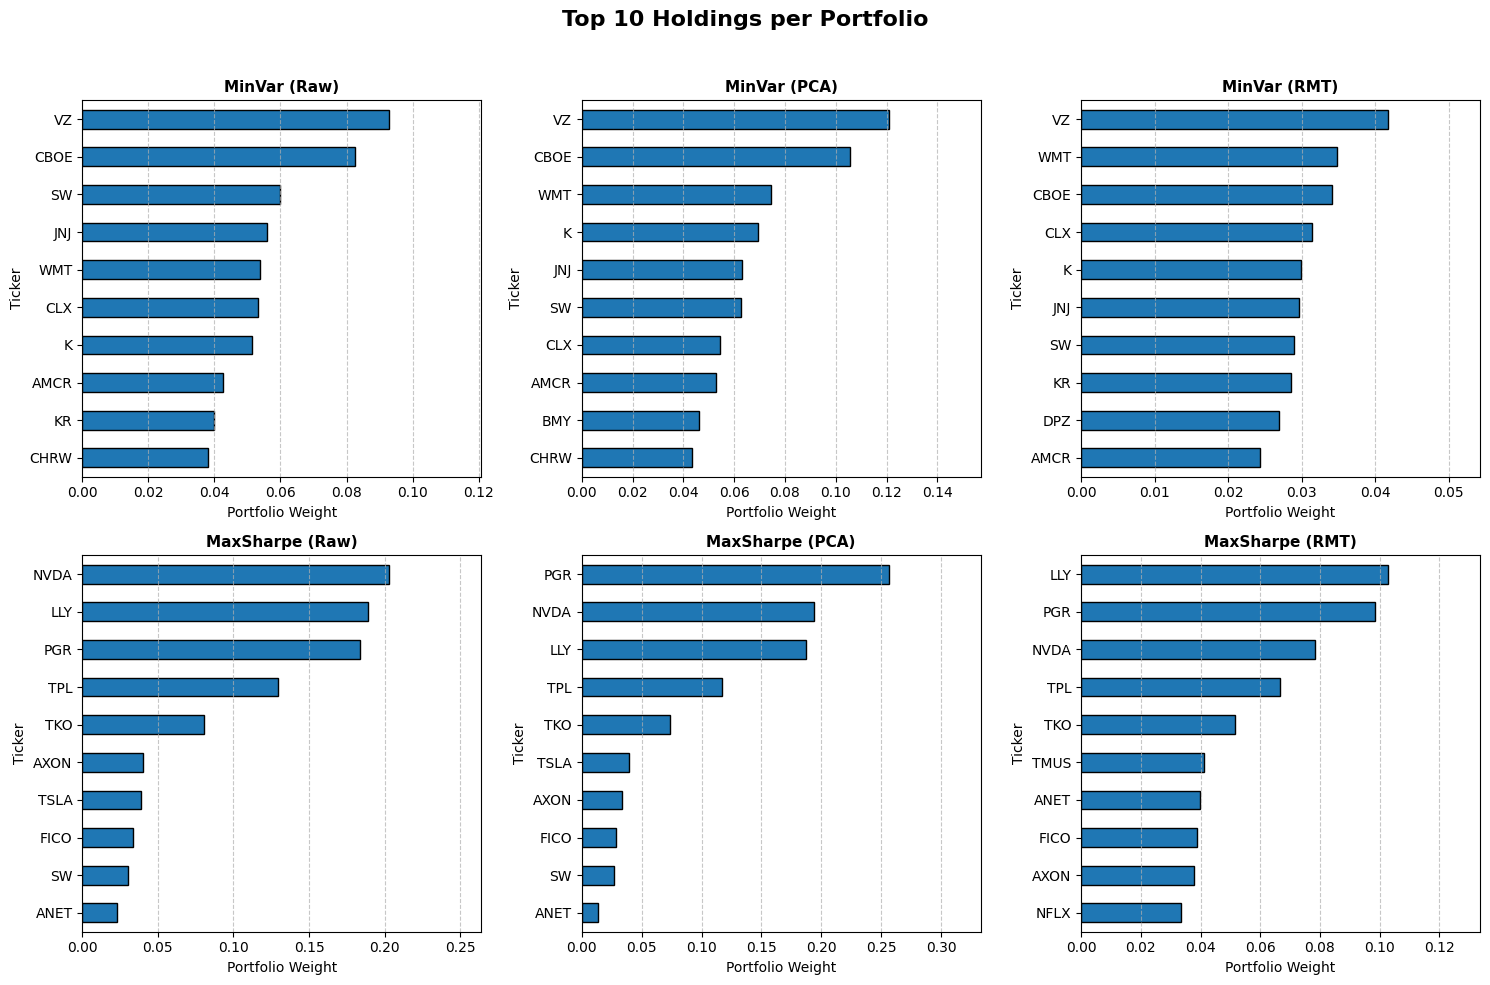

In [27]:
# barplots of top 10 holdings (one line)
mp.plot_top10_holdings(tops)

The weight plots show that the **MinVol** and **MaxSharpe** portfolios rely on very different economic exposures, and that covariance cleaning mainly adjusts concentration rather than changing the underlying themes. The MinVol portfolios (top row) consistently load on **stable, low-beta, defensive stocks** such as VZ, CBOE, WMT, JNJ, and consumer-staples names (CLX, K), reflecting the optimizer’s preference for low variance and low correlation. PCA and RMT shrink some extreme weights in the raw version, but the defensive profile is unchanged. In contrast, the MaxSharpe portfolios (bottom row) exhibit **large concentrated bets** in high expected return names such as NVDA, LLY, PGR, TPL, TKO, consistent with Sharpe-maximization under a 4% risk-free rate. PCA tends to amplify concentration (e.g., very high PGR weight), while RMT diffuses weights slightly but preserves the same growth/quality tilt. Overall, the holdings confirm that MinVol behaves like a diversified defensive basket, whereas MaxSharpe behaves like a targeted high-alpha set of exposures, with covariance-cleaning methods affecting weight magnitude more than the qualitative asset selection.



## References
Avellaneda, M., & Lee, J. H. (2010). Statistical arbitrage in the US equities market. Quantitative Finance, 10(7), 761-782.
 
Bloomberg L.P. (n.d.). United States government bonds: Rates & markets. Bloomberg. https://www.bloomberg.com/markets/rates-bonds/government-bonds/us
 
Giacomo Livan, Marcel Novaes, & Pierpaolo Vivo (2017). Introduction to Random Matrices Theory and Practice. https://arxiv.org/pdf/1712.07903

Horváth, Ágota & Kazarian, Kazaros. (2017). The Dirichlet problem in weighted norm. Acta Mathematica Hungarica. 153. 34-. 10.1007/s10474-017-0749-8.

Marchenko, V. A., & Pastur, L. A. (1967). Distribution of eigenvalues for some sets of random matrices. Mathematics of the USSR-Sbornik, 1(4), 457.

Markowitz, H. (1952). Portfolio selection. The Journal of Finance, 7(1), 77-91.
                                                      
Plotly Technologies Inc. (n.d.). Markowitz portfolio optimization in Python/v3. Retrieved from https://plotly.com/python/v3/ipython-notebooks/markowitz-portfolio-optimization/